In [1]:
import torch
import os
import skimage
from PIL import Image
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from training.locallogger import LocalLogger2D
from training.trainer import MRTrainer
from datasets.imagesignal import ImageSignal
from networks.mrnet import MRFactory
from datasets.pyramids import create_MR_structure
from datasets.sampling import make2Dcoords
import yaml
from yaml.loader import SafeLoader
import matplotlib.pyplot as plt

In [2]:
os.environ["WANDB_NOTEBOOK_NAME"] = "train-wb.ipynb"
BASE_DIR = Path('.').absolute().parents[0]
IMAGE_PATH = BASE_DIR.joinpath('img')
MODEL_PATH = BASE_DIR.joinpath('models')

In [3]:
project_name = "test_mnet_f2"
#-- hyperparameters in configs --#
config_file = '../configs/config_base_l_net.yml'
with open(config_file) as f:
    hyper = yaml.load(f, Loader=SafeLoader)
    print(hyper)

{'omega_0': 32, 'in_features': 2, 'hidden_features': 256, 'hidden_layers': 3, 'superposition_w0': True, 'hidden_omega_0': 30, 'sampling_scheme': 'uniform', 'multiresolution': 'capacity', 'max_epochs_per_stage': 200, 'opt_method': 'Adam', 'loss_function': ['d0'], 'lr': 0.0001, 'loss_tol': 1e-14, 'diff_tol': 1e-11, 'batch_pixels_perc': 0.5, 'batch_size': 1, 'image_name': 'camera.png', 'width': 512, 'height': 512, 'channels': 1, 'max_stages': 1, 'model': 'L', 'useattributes': True, 'device': 'cuda', 'eval_device': 'cuda', 'bias': False}


In [4]:
base_signal = ImageSignal.init_fromfile(
                    os.path.join(IMAGE_PATH, hyper['image_name']),
                    useattributes=hyper.get('useattributes', False),
                    batch_pixels_perc=hyper['batch_pixels_perc'],
                    width=hyper['width'],height= hyper['height'])
if hyper['multiresolution'] == 'capacity':
    train_dataloader = DataLoader(base_signal, batch_size=hyper['batch_size'], shuffle=True, pin_memory=True, num_workers=0)
    test_dataloader = DataLoader(base_signal, batch_size=hyper['batch_size'], pin_memory=True, num_workers=0)
else:
    pyramid = create_MR_structure(base_signal, hyper['max_stages'],type_pyr="pyramid")
    tower = create_MR_structure(base_signal, hyper['max_stages'],type_pyr="tower")

    trainsource = pyramid if hyper['multiresolution'] == 'pyramid' else tower
    train_dataloader = [DataLoader(signal, shuffle=True, batch_size=hyper['batch_size']) 
                        for signal in trainsource]
    test_dataloader = [DataLoader(signal, batch_size=hyper['batch_size']) 
                        for signal in tower]

In [5]:
locallogger = LocalLogger2D(project_name,
                            f"{hyper['model']}{hyper['multiresolution'][0].upper()}{hyper['image_name'][0:4]}_",
                            hyper,
                            BASE_DIR)
mrmodel = MRFactory.from_dict(hyper)
print("Model: ", type(mrmodel))
mrtrainer = MRTrainer.init_from_dict(mrmodel, train_dataloader, test_dataloader, locallogger, hyper)
mrtrainer.train(hyper['device'])

Model:  <class 'networks.mrnet.LNet'>
Stage 1 starting
MRModule(
  (first_layer): SineLayer(
    (linear): Linear(in_features=2, out_features=256, bias=False)
  )
  (middle_layers): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (final_linear): Linear(in_features=256, out_features=1, bias=True)
)
Training finished after 200 epochs


In [6]:
filename = f"{hyper['model']}{hyper['multiresolution'][0].upper()}{hyper['image_name'][0:4]}.pth"
path = os.path.join(MODEL_PATH, filename)

MRFactory.save(mrmodel, path)

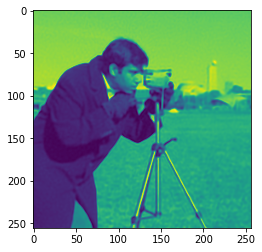

In [7]:
mrmodel_eval = MRFactory.load_state_dict(path)

output = mrmodel_eval(make2Dcoords(256,256))
model_out = torch.clamp(output['model_out'], 0.0, 1.0)

plt.imshow(model_out.cpu().view(256,256).detach().numpy())